# Join Datasets
Access the data for Chloris and Planet, rename the columns, and join variables from both datasets into a single dataset. 

### Import required packages.

In [1]:
import snowflake.connector
import yaml
import pandas as pd
import matplotlib.pyplot as plt

### Connect to snowflake.
Note that the access credentials to the snowflake database are not included below. The code should be modified where shown to include the access credentials provided to you. 

In [5]:
# Pull database information from the config yaml file. 
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Connect to the snowflake database using info from config file.
conn = snowflake.connector.connect(
    account = config['database-info']['account'], # Replace 'config['database-info']['account']' with the database account name. 
    user = config['database-info']['user'], # Replace 'config['database-info']['user']' with the database username.
    password = config['database-info']['password'], # Replace 'config['database-info']['password']' with the database password.
    warehouse = config['database-info']['warehouse'], # Replace 'config['database-info']['warehouse']' with the database warehouse name.
    database = config['database-info']['database'], # Replace 'config['database-info']['database']' with the database name.
)

### Pull the data of interest.
The SQL query below demonstrates how to access variables from multiple datasets using aliases. In the example below, we use 'c' to refer to the Chloris Forest Cover dataset, and 'p' to refer to the Planet Forest Carbon dataset. The full SQL query is broken down and explained below.

**SQL Query Breakdown:**

We begin by selecting all the variables we are interested in from both the Chloris dataset (indicated by 'c') and the Planet dataset (indicated by 'p'). Some of the variables are renamed using the SQL clause 'AS' (e.g. Chloris aboveground biomass is called 'STOCK' in the raw dataset, but in the example below, we rename it 'chloris_agb'). To better compare the Chloris and Planet data, we also convert Planet aboveground carbon density data to biomass data by dividing by 0.476 and then renaming this column 'planet_agb'.
```SQL
    SELECT
        c.year,
        c.lon,
        c.lat,
        c.stock AS chloris_agb,
        p.aboveground_carbon_density AS planet_acd,
        p.aboveground_carbon_density / 0.476 AS planet_agb,
        (c.stock + (p.aboveground_carbon_density / 0.476)) / 2 AS mean_agb,
        LEAST(c.stock, p.aboveground_carbon_density / 0.476) AS min_agb
```

Next, we use the SQL clause 'FROM' to indicate which dataset the variables should be pulled from. Note that we also define the alias 'c' to refer to the Chloris dataset here.
```SQL
    FROM
        chloris.forest_cover c
```

Finally, we perform an outer join with the Planet dataset (and define the dataset alias 'p'). To have the join perform as expected, we indicate which variables should be aligned between the two datasets. In this case, we expect all of the years and lat and lon values to match between the two datasets, so these are used as the fields on which the join is defined. At this point, we also define the year of data that we want returned using the clause 'WHERE'. 
```SQL
    FULL OUTER JOIN
        planet.pv_forest_carbon p
        ON
        c.year = p.year AND c.lon = p.lon AND c.lat = p.lat
    WHERE
        c.year = 2020
```

In [6]:
# Define the SQL query to get both Chloris and Planet data for 2020.
sql_query = """
    SELECT
        c.year,
        c.lon,
        c.lat,
        c.stock AS chloris_agb,
        p.aboveground_carbon_density AS planet_acd,
        p.aboveground_carbon_density / 0.476 AS planet_agb,
        (c.stock + (p.aboveground_carbon_density / 0.476)) / 2 AS mean_agb,
        LEAST(c.stock, p.aboveground_carbon_density / 0.476) AS min_agb
    FROM
        chloris.forest_cover c
    FULL OUTER JOIN
        planet.pv_forest_carbon p
        ON
        c.year = p.year AND c.lon = p.lon AND c.lat = p.lat
    WHERE
        c.year = 2020
    """

# Execute the query and get the rows and columns of data.
cursor = conn.cursor()
cursor.execute(sql_query)
data_rows = cursor.fetchall()
data_columns = [desc[0] for desc in cursor.description]
cursor.close()
conn.close()

### Convert to dataframe and plot.

In [7]:
# Format the data into a pandas dataframe.
data_df = pd.DataFrame(data_rows, columns=data_columns)
data_df.head(5)

,YEAR,LON,LAT,CHLORIS_AGB,PLANET_ACD,PLANET_AGB,MEAN_AGB,MIN_AGB
0,2020,-2.77862500,57.12337500,None,0E-8,0E-12,None,None
1,2020,-2.77912500,57.12262500,104.00000000,49.00000000,102.941176470588,103.470588235294,102.941176470588
2,2020,-2.77962500,57.12212500,101.00000000,42.00000000,88.235294117647,94.617647058824,88.235294117647
3,2020,-2.77887500,57.12212500,128.00000000,53.00000000,111.344537815126,119.672268907563,111.344537815126
4,2020,-2.77987500,57.12187500,80.00000000,0E-8,0E-12,40.000000000000,0E-12


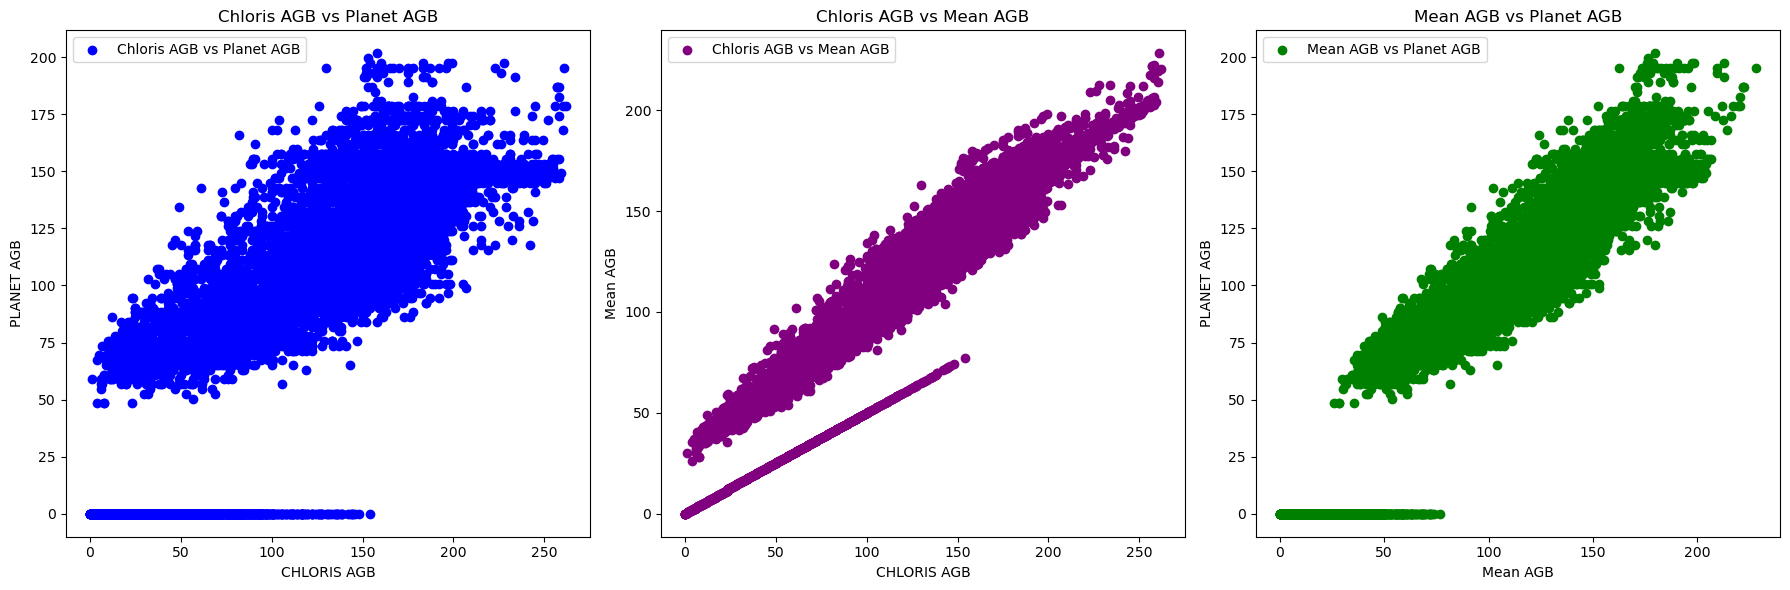

In [8]:
# Create a figure with 3 subplots to visualize joined dataset.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Chloris AGB vs Planet AGB
axes[0].scatter(data_df['CHLORIS_AGB'], data_df['PLANET_AGB'], color='blue', label='Chloris AGB vs Planet AGB')
axes[0].set_xlabel('CHLORIS AGB')
axes[0].set_ylabel('PLANET AGB')
axes[0].set_title('Chloris AGB vs Planet AGB')
axes[0].legend()

# Plot 2: Chloris AGB vs Mean AGB
axes[1].scatter(data_df['CHLORIS_AGB'], data_df['MEAN_AGB'], color='purple', label='Chloris AGB vs Mean AGB')
axes[1].set_xlabel('CHLORIS AGB')
axes[1].set_ylabel('Mean AGB')
axes[1].set_title('Chloris AGB vs Mean AGB')
axes[1].legend()

# Plot 3: Mean AGB vs Planet AGB
axes[2].scatter(data_df['MEAN_AGB'], data_df['PLANET_AGB'], color='green', label='Mean AGB vs Planet AGB')
axes[2].set_xlabel('Mean AGB')
axes[2].set_ylabel('PLANET AGB')
axes[2].set_title('Mean AGB vs Planet AGB')
axes[2].legend()

# Show the resulting plots.
plt.tight_layout()
plt.show()